In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import dataset
import torch
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from sklearn import metrics
import time

In [12]:
transform = transforms.Compose([
    # to-tensor
    transforms.ToTensor(),
    # resize
    transforms.Resize(128),
    # center-crop
    transforms.CenterCrop(128),
    # normalize
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
])

inception_preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [13]:
incidents = dataset.IncidentsDataset("Incidents-subset", transform=inception_preprocess)

In [14]:
nSamples = incidents.__len__()
nClasses = len(incidents.labels)
imgShape = incidents.__getitem__(0)[0].shape

print("Number of samples: ", nSamples)
print("Number of classes: ", nClasses)
print("Shape of an image: ", imgShape)

Number of samples:  7004
Number of classes:  12
Shape of an image:  torch.Size([3, 299, 299])


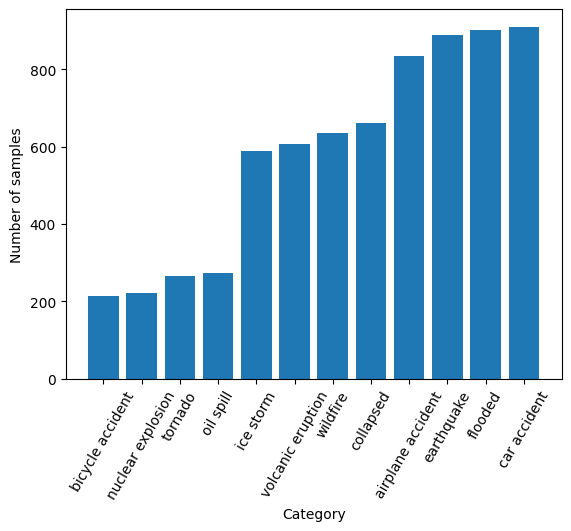

In [15]:
target, counts = np.unique(incidents.targets, return_counts=True)

idx = np.argsort(counts)

_, ax = plt.subplots()

ax.bar(incidents.labels[target][idx], counts[idx]) #, width=1, edgecolor="white", linewidth=.7)
plt.ylabel("Number of samples")
plt.xlabel("Category")
plt.xticks(rotation=60)
plt.savefig("dataset_labels")
plt.show()

In [16]:
from tqdm import tqdm

def train_model(model, num_epochs, train_loader, test_loader, criterion, optimizer):
    start = time.time()
    accuracy_history = {'train': [], 'test': []}
    loss_history = {'train': [], 'test': []}

    for epoch in range(num_epochs):
        print(f"Epoch: {epoch + 1}/{num_epochs}")

        running_loss_train, running_loss_test = 0.0, 0.0
        running_corrects_train, running_corrects_test = 0, 0

        print("Training...")
        model.train()  # Put the network in train mode
        for i, (x_batch, y_batch) in enumerate(tqdm(train_loader)):
            x_batch = x_batch.to(device)  # Move the data to the device that is used
            y_batch = y_batch.type(torch.LongTensor) # <---- Here (casting)
            y_batch = y_batch.to(device)

            # Compute prediction and loss
            # output = model(x_batch)

            # Required for inception model
            output, _ = model(x_batch)
            loss_train = criterion(output, y_batch)

            # Backpropagation
            optimizer.zero_grad()  # Set all currenly stored gradients to zero
            loss_train.backward()
            optimizer.step()

            # Compute relevant metrics
            _, preds = torch.max(output, dim=1)  # Get the labels with highest output probability

            running_loss_train += loss_train.item() * x_batch.size(0)
            running_corrects_train += torch.sum(preds == y_batch.data)

            elapsed = time.time() - start  # Keep track of how much time has elapsed

        print("Evaluating...")
        model.eval()  # Put the network in eval mode
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch = x_batch.to(device)  # Move the data to the device that is used
            y_batch = y_batch.type(torch.LongTensor) # <---- Here (casting)
            y_batch = y_batch.to(device)

            output = model(x_batch)
            loss_test = criterion(output, y_batch)
            _, preds = torch.max(output, dim=1)

            running_loss_test += loss_test.item() * x_batch.size(0)
            running_corrects_test += torch.sum(preds == y_batch.data)

        accuracy_history['train'].append(running_corrects_train/len(train_split))
        accuracy_history['test'].append(running_corrects_test/len(test_split))

        loss_history['train'].append(running_loss_train)
        loss_history['test'].append(running_loss_test)

        print(f'Accuracy on the train set: {running_corrects_train / len(train_split):.3f}. Loss: {running_loss_train:.3f}')
        print(f'Accuracy on the test set: {running_corrects_test / len(test_split):.3f}. Loss: {running_loss_test:.3f}')

    return model, accuracy_history, loss_history, time.time() - start

### Cross-Validation

In [17]:
import os

def save_curves(curves, model_name, mode, num_epochs, num_splits):
    train_curves, test_curves = np.zeros((num_splits, num_epochs)), np.zeros((num_splits, num_epochs))

    for i, curve in enumerate(curves):
        train, test = curve['train'], curve['test']
        if mode == "accuracy":
            train = [train[i].item() for i in range(train.__len__())]
            test = [test[i].item() for i in range(test.__len__())]

        for j, (train_value, test_value) in enumerate(zip(train, test)):
            train_curves[i, j] = train_value
            test_curves[i, j] = test_value

    dir_name = f"{model_name}"
    dir_exists = os.path.exists(dir_name)

    if not dir_exists:
        os.mkdir(dir_name)
    np.save(f"{dir_name}/{model_name}_train_{mode}.npy", train_curves)
    np.save(f"{dir_name}/{model_name}_test_{mode}.npy", test_curves)

In [18]:
from torchvision import models

def get_model(name):
    if name == "inception":
        model = models.inception_v3(weights=models.Inception_V3_Weights)
        model.fc = torch.nn.Linear(2048, nClasses)
    elif name == "resnet":
        model = models.resnet50(weights=models.ResNet50_Weights)
        model.fc = torch.nn.Linear(2048, nClasses)
    elif name == "mobilenet":
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights)
        model.classifier[1] = torch.nn.Linear(1280, nClasses)
    else:
        model = None

    return model

In [19]:
def get_recall_f1_precision_accuracy_confusion_matrix(model, test_loader):
    predictions = []
    ground_truth = []
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            ground_truth.append(labels.numpy())
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predictions.append(predicted.cpu().numpy())

    ground_truth = np.concatenate(ground_truth)
    predictions = np.concatenate(predictions)
    accuracy = metrics.accuracy_score(ground_truth, predictions)
    f1 = metrics.f1_score(ground_truth, predictions, average='weighted')
    precision = metrics.precision_score(ground_truth, predictions, average='weighted')
    recall = metrics.recall_score(ground_truth, predictions, average='weighted')
    confusion_matrix = metrics.confusion_matrix(ground_truth, predictions)

    return recall, f1, precision, accuracy, confusion_matrix



In [20]:
from sklearn.model_selection import KFold
from torchsampler import ImbalancedDatasetSampler
import json

num_splits = 5
kfold = KFold(n_splits=num_splits, shuffle=True)
batch_size = 32

num_epochs = 10

for model_name in ["inception"]:
    accuracy_curves = []
    loss_curves = []
    fold = 0
    recalls, f1s, precisions, accuracies, conf_matrices, times = [], [], [], [], [], []

    for train, test in kfold.split(incidents):
        # Creating model, the optimizers and criterion
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = get_model(model_name)
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = torch.nn.CrossEntropyLoss()

        # Splitting data
        train_split = Subset(incidents, train)
        test_split = Subset(incidents, test)

        targets, counts = np.unique(incidents.targets[train_split.indices], return_counts=True)
        class_weights = [1/counts[i] for i in targets]
        weights = [class_weights[t] for t in incidents.targets[train]]

        sampler = WeightedRandomSampler(weights=weights, num_samples=len(train_split), replacement=True)

        train_loader = DataLoader(train_split, batch_size=batch_size, sampler=sampler)
        test_loader = DataLoader(test_split, batch_size=batch_size)

        # Training the model
        model, accuracy_history, loss_history, elapsed_time = train_model(model, num_epochs, train_loader, test_loader, criterion, optimizer)

        # Saving the model and its indices, so its train and test data can be reused
        torch.save(model.state_dict(), f"models/{model.__class__.__name__}_{fold}.pt")
        with open(f"models/{model.__class__.__name__}_{fold}_indices", 'w') as indices_file:
            indices_file.write(json.dumps({'train': train.tolist(), 'test': test.tolist()}))

        # Add all the metrics to lists, so they can be averaged and stored in files
        accuracy_curves.append(accuracy_history)
        loss_curves.append(loss_history)
        fold += 1

        recall, f1, precision, accuracy, conf_matrix = get_recall_f1_precision_accuracy_confusion_matrix(model, test_loader)
        recalls.append(recall)
        f1s.append(f1)
        precisions.append(precision)
        accuracies.append(accuracy)
        conf_matrices.append(conf_matrix)
        times.append(elapsed_time)

    # Saving all the metrics to files
    average_metrics = {'recall': sum(recalls)/len(recalls), 'f1': sum(f1s)/len(f1s), 'precision': sum(precisions)/len(precisions), 'accuracy': sum(accuracies)/len(accuracies), 'time': times}
    save_curves(accuracy_curves, model.__class__.__name__, "accuracy", num_epochs, num_splits)
    save_curves(loss_curves, model.__class__.__name__, "loss", num_epochs, num_splits)
    np.save(f"{model.__class__.__name__}/conf_matrix.npy", np.array(conf_matrices))

    with open(f"{model.__class__.__name__}/metrics.txt", 'w') as metrics_file:
        metrics_file.write(json.dumps(average_metrics))


C:\Users\koend\anaconda3\envs\Data-Science\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1/10
Training...


100%|██████████| 176/176 [02:18<00:00,  1.27it/s]


Evaluating...
Accuracy on the train set: 0.574. Loss: 7504.394
Accuracy on the test set: 0.517. Loss: 2120.463
Epoch: 2/10
Training...


100%|██████████| 176/176 [04:07<00:00,  1.40s/it]


Evaluating...
Accuracy on the train set: 0.705. Loss: 5255.070
Accuracy on the test set: 0.577. Loss: 1836.248
Epoch: 3/10
Training...


100%|██████████| 176/176 [03:40<00:00,  1.25s/it]


Evaluating...
Accuracy on the train set: 0.750. Loss: 4369.826
Accuracy on the test set: 0.603. Loss: 1859.047
Epoch: 4/10
Training...


100%|██████████| 176/176 [03:38<00:00,  1.24s/it]


Evaluating...
Accuracy on the train set: 0.760. Loss: 4158.580
Accuracy on the test set: 0.618. Loss: 1732.636
Epoch: 5/10
Training...


100%|██████████| 176/176 [03:37<00:00,  1.24s/it]


Evaluating...
Accuracy on the train set: 0.826. Loss: 2999.188
Accuracy on the test set: 0.665. Loss: 1525.077
Epoch: 6/10
Training...


100%|██████████| 176/176 [03:34<00:00,  1.22s/it]


Evaluating...
Accuracy on the train set: 0.860. Loss: 2398.268
Accuracy on the test set: 0.731. Loss: 1348.905
Epoch: 7/10
Training...


100%|██████████| 176/176 [03:32<00:00,  1.21s/it]


Evaluating...
Accuracy on the train set: 0.867. Loss: 2321.422
Accuracy on the test set: 0.661. Loss: 1840.619
Epoch: 8/10
Training...


100%|██████████| 176/176 [03:36<00:00,  1.23s/it]


Evaluating...
Accuracy on the train set: 0.876. Loss: 2219.800
Accuracy on the test set: 0.704. Loss: 1821.991
Epoch: 9/10
Training...


100%|██████████| 176/176 [03:33<00:00,  1.21s/it]


Evaluating...
Accuracy on the train set: 0.883. Loss: 2077.046
Accuracy on the test set: 0.742. Loss: 1235.327
Epoch: 10/10
Training...


100%|██████████| 176/176 [03:34<00:00,  1.22s/it]


Evaluating...
Accuracy on the train set: 0.904. Loss: 1691.576
Accuracy on the test set: 0.707. Loss: 1507.668


C:\Users\koend\anaconda3\envs\Data-Science\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1/10
Training...


100%|██████████| 176/176 [03:33<00:00,  1.21s/it]


Evaluating...
Accuracy on the train set: 0.606. Loss: 7046.936
Accuracy on the test set: 0.488. Loss: 2270.398
Epoch: 2/10
Training...


100%|██████████| 176/176 [03:30<00:00,  1.20s/it]


Evaluating...
Accuracy on the train set: 0.707. Loss: 5047.983
Accuracy on the test set: 0.600. Loss: 1684.783
Epoch: 3/10
Training...


100%|██████████| 176/176 [03:33<00:00,  1.21s/it]


Evaluating...
Accuracy on the train set: 0.757. Loss: 4165.563
Accuracy on the test set: 0.504. Loss: 2621.432
Epoch: 4/10
Training...


100%|██████████| 176/176 [03:30<00:00,  1.20s/it]


Evaluating...
Accuracy on the train set: 0.785. Loss: 3750.863
Accuracy on the test set: 0.651. Loss: 1613.023
Epoch: 5/10
Training...


100%|██████████| 176/176 [03:30<00:00,  1.19s/it]


Evaluating...
Accuracy on the train set: 0.825. Loss: 3081.394
Accuracy on the test set: 0.674. Loss: 1406.874
Epoch: 6/10
Training...


100%|██████████| 176/176 [03:31<00:00,  1.20s/it]


Evaluating...
Accuracy on the train set: 0.847. Loss: 2668.272
Accuracy on the test set: 0.640. Loss: 1933.726
Epoch: 7/10
Training...


100%|██████████| 176/176 [03:33<00:00,  1.21s/it]


Evaluating...
Accuracy on the train set: 0.849. Loss: 2662.494
Accuracy on the test set: 0.617. Loss: 2264.289
Epoch: 8/10
Training...


100%|██████████| 176/176 [03:31<00:00,  1.20s/it]


Evaluating...
Accuracy on the train set: 0.881. Loss: 2022.302
Accuracy on the test set: 0.638. Loss: 1926.275
Epoch: 9/10
Training...


100%|██████████| 176/176 [03:33<00:00,  1.21s/it]


Evaluating...
Accuracy on the train set: 0.858. Loss: 2469.066
Accuracy on the test set: 0.702. Loss: 1487.096
Epoch: 10/10
Training...


100%|██████████| 176/176 [03:32<00:00,  1.21s/it]


Evaluating...
Accuracy on the train set: 0.899. Loss: 1804.355
Accuracy on the test set: 0.690. Loss: 1554.105


C:\Users\koend\anaconda3\envs\Data-Science\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1/10
Training...


100%|██████████| 176/176 [03:34<00:00,  1.22s/it]


Evaluating...
Accuracy on the train set: 0.583. Loss: 7253.355
Accuracy on the test set: 0.511. Loss: 2199.251
Epoch: 2/10
Training...


100%|██████████| 176/176 [03:31<00:00,  1.20s/it]


Evaluating...
Accuracy on the train set: 0.686. Loss: 5372.723
Accuracy on the test set: 0.571. Loss: 1902.704
Epoch: 3/10
Training...


100%|██████████| 176/176 [03:34<00:00,  1.22s/it]


Evaluating...
Accuracy on the train set: 0.755. Loss: 4253.496
Accuracy on the test set: 0.575. Loss: 2177.210
Epoch: 4/10
Training...


100%|██████████| 176/176 [03:31<00:00,  1.20s/it]


Evaluating...
Accuracy on the train set: 0.802. Loss: 3458.453
Accuracy on the test set: 0.602. Loss: 1952.267
Epoch: 5/10
Training...


100%|██████████| 176/176 [03:34<00:00,  1.22s/it]


Evaluating...
Accuracy on the train set: 0.808. Loss: 3253.231
Accuracy on the test set: 0.664. Loss: 1606.413
Epoch: 6/10
Training...


100%|██████████| 176/176 [03:36<00:00,  1.23s/it]


Evaluating...
Accuracy on the train set: 0.849. Loss: 2630.882
Accuracy on the test set: 0.724. Loss: 1233.968
Epoch: 7/10
Training...


100%|██████████| 176/176 [03:31<00:00,  1.20s/it]


Evaluating...
Accuracy on the train set: 0.847. Loss: 2621.833
Accuracy on the test set: 0.670. Loss: 1505.602
Epoch: 8/10
Training...


100%|██████████| 176/176 [03:34<00:00,  1.22s/it]


Evaluating...
Accuracy on the train set: 0.858. Loss: 2505.424
Accuracy on the test set: 0.678. Loss: 1491.102
Epoch: 9/10
Training...


100%|██████████| 176/176 [03:32<00:00,  1.21s/it]


Evaluating...
Accuracy on the train set: 0.887. Loss: 2067.806
Accuracy on the test set: 0.720. Loss: 1316.267
Epoch: 10/10
Training...


100%|██████████| 176/176 [03:32<00:00,  1.21s/it]


Evaluating...
Accuracy on the train set: 0.899. Loss: 1753.116
Accuracy on the test set: 0.702. Loss: 1674.680


C:\Users\koend\anaconda3\envs\Data-Science\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1/10
Training...


100%|██████████| 176/176 [03:34<00:00,  1.22s/it]


Evaluating...
Accuracy on the train set: 0.590. Loss: 7151.009
Accuracy on the test set: 0.553. Loss: 1925.316
Epoch: 2/10
Training...


100%|██████████| 176/176 [03:32<00:00,  1.21s/it]


Evaluating...
Accuracy on the train set: 0.702. Loss: 5065.143
Accuracy on the test set: 0.620. Loss: 1885.732
Epoch: 3/10
Training...


100%|██████████| 176/176 [03:34<00:00,  1.22s/it]


Evaluating...
Accuracy on the train set: 0.765. Loss: 4122.535
Accuracy on the test set: 0.615. Loss: 1845.911
Epoch: 4/10
Training...


100%|██████████| 176/176 [03:32<00:00,  1.20s/it]


Evaluating...
Accuracy on the train set: 0.810. Loss: 3387.520
Accuracy on the test set: 0.613. Loss: 1877.688
Epoch: 5/10
Training...


100%|██████████| 176/176 [03:31<00:00,  1.20s/it]


Evaluating...
Accuracy on the train set: 0.826. Loss: 2956.767
Accuracy on the test set: 0.693. Loss: 1423.893
Epoch: 6/10
Training...


100%|██████████| 176/176 [03:32<00:00,  1.21s/it]


Evaluating...
Accuracy on the train set: 0.841. Loss: 2800.683
Accuracy on the test set: 0.620. Loss: 1940.537
Epoch: 7/10
Training...


100%|██████████| 176/176 [03:32<00:00,  1.21s/it]


Evaluating...
Accuracy on the train set: 0.829. Loss: 2950.575
Accuracy on the test set: 0.664. Loss: 1661.054
Epoch: 8/10
Training...


100%|██████████| 176/176 [03:32<00:00,  1.21s/it]


Evaluating...
Accuracy on the train set: 0.891. Loss: 1903.366
Accuracy on the test set: 0.647. Loss: 1836.025
Epoch: 9/10
Training...


100%|██████████| 176/176 [03:34<00:00,  1.22s/it]


Evaluating...
Accuracy on the train set: 0.902. Loss: 1788.170
Accuracy on the test set: 0.724. Loss: 1431.107
Epoch: 10/10
Training...


100%|██████████| 176/176 [03:31<00:00,  1.20s/it]


Evaluating...
Accuracy on the train set: 0.889. Loss: 1924.237
Accuracy on the test set: 0.717. Loss: 1514.802


C:\Users\koend\anaconda3\envs\Data-Science\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1/10
Training...


100%|██████████| 176/176 [03:33<00:00,  1.21s/it]


Evaluating...
Accuracy on the train set: 0.595. Loss: 7159.204
Accuracy on the test set: 0.543. Loss: 2119.587
Epoch: 2/10
Training...


100%|██████████| 176/176 [03:36<00:00,  1.23s/it]


Evaluating...
Accuracy on the train set: 0.710. Loss: 4985.433
Accuracy on the test set: 0.625. Loss: 1711.238
Epoch: 3/10
Training...


100%|██████████| 176/176 [03:31<00:00,  1.20s/it]


Evaluating...
Accuracy on the train set: 0.764. Loss: 4005.513
Accuracy on the test set: 0.641. Loss: 1772.971
Epoch: 4/10
Training...


100%|██████████| 176/176 [03:32<00:00,  1.21s/it]


Evaluating...
Accuracy on the train set: 0.789. Loss: 3646.656
Accuracy on the test set: 0.686. Loss: 1572.391
Epoch: 5/10
Training...


100%|██████████| 176/176 [03:31<00:00,  1.20s/it]


Evaluating...
Accuracy on the train set: 0.829. Loss: 3021.070
Accuracy on the test set: 0.624. Loss: 1856.898
Epoch: 6/10
Training...


100%|██████████| 176/176 [03:31<00:00,  1.20s/it]


Evaluating...
Accuracy on the train set: 0.857. Loss: 2536.588
Accuracy on the test set: 0.693. Loss: 1458.958
Epoch: 7/10
Training...


100%|██████████| 176/176 [03:33<00:00,  1.21s/it]


Evaluating...
Accuracy on the train set: 0.863. Loss: 2382.959
Accuracy on the test set: 0.726. Loss: 1359.333
Epoch: 8/10
Training...


100%|██████████| 176/176 [03:33<00:00,  1.21s/it]


Evaluating...
Accuracy on the train set: 0.873. Loss: 2210.314
Accuracy on the test set: 0.666. Loss: 1682.807
Epoch: 9/10
Training...


100%|██████████| 176/176 [03:33<00:00,  1.22s/it]


Evaluating...
Accuracy on the train set: 0.898. Loss: 1837.503
Accuracy on the test set: 0.682. Loss: 1594.691
Epoch: 10/10
Training...


100%|██████████| 176/176 [03:32<00:00,  1.21s/it]


Evaluating...
Accuracy on the train set: 0.895. Loss: 1777.734
Accuracy on the test set: 0.707. Loss: 1513.326


In [21]:
7004*.8

5603.200000000001

In [22]:
incidents.targets[Subset(incidents, [0, 1, 2]).indices]

array([0, 0, 0])